In [63]:
# import packages needed to run the code
# style as following: import ["package name"] (as [variable name]) ie. we call a function from matplotlib.pyplot as plt.function
#                     from ["package name"] import ["function"]
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as collections
import matplotlib.dates as dates
import glob
import pandas as pd
import os
from scipy.interpolate import CubicSpline
import datetime
import csv
from dateutil.parser import parse
import math
import ipywidgets as widgets
from ipywidgets import interactive
from psychrochart import PsychroChart
from scipy.interpolate import splrep, BSpline


In [64]:
# Get data file names from path with a csv format
path = r'.\test'
filenames = glob.glob(path + "/*.csv")

In [65]:
# Print names of all files in the path with csv format
names = [os.path.splitext(x)[0] for x in [os.path.basename(x) for x in filenames]]
print(names)
# Print number of files in the path with csv format
print("Number of Sensors= " + str( int(len(names))))

['Cabinet_227', 'Court_228_2', 'Court_229_2', 'East_212_2', 'East_212_Ipad', 'East_213_2', 'East_213_Sushibar_2', 'East_214', 'East_215_2', 'East_216_2', 'East_217_2', 'East_218_2', 'Focus_211', 'Found_Space_010', 'Main_E1', 'Main_E2', 'Main_Hall', 'Main_W1', 'Main_W2', 'North_202', 'North_203', 'North_205', 'North_208', 'Outdoor_1_2', 'South_219', 'South_221_2', 'South_222', 'South_223', 'South_224', 'South_225', 'South_226', 'West_N1_2', 'West_S1_2', 'W_Annex_201A_2']
Number of Sensors= 34


In [66]:
# Print full filename with location (path)
print(filenames)

# Function below tries to find if something is of date-time format (just defining, not running the code)
# Create function that looks at a string (collection of letters and numbers (not treated as a number)) and tries to 
# determine if it is a date. If it is a date, the function will return/output True, otherwise False
# is_date = function name, input= string, fuzzy (fuzzy is automatically set to False unless specified as True)
def is_date(string, fuzzy=False):
    """
    Return whether the string can be interpreted as a date.

    :param string: str, string to check for date
    :param fuzzy: bool, ignore unknown tokens in string if True
    """
    try: 
        parse(string, fuzzy=fuzzy)
        return True

    except ValueError:
        return False
    

['.\\test\\Cabinet_227.csv', '.\\test\\Court_228_2.csv', '.\\test\\Court_229_2.csv', '.\\test\\East_212_2.csv', '.\\test\\East_212_Ipad.csv', '.\\test\\East_213_2.csv', '.\\test\\East_213_Sushibar_2.csv', '.\\test\\East_214.csv', '.\\test\\East_215_2.csv', '.\\test\\East_216_2.csv', '.\\test\\East_217_2.csv', '.\\test\\East_218_2.csv', '.\\test\\Focus_211.csv', '.\\test\\Found_Space_010.csv', '.\\test\\Main_E1.csv', '.\\test\\Main_E2.csv', '.\\test\\Main_Hall.csv', '.\\test\\Main_W1.csv', '.\\test\\Main_W2.csv', '.\\test\\North_202.csv', '.\\test\\North_203.csv', '.\\test\\North_205.csv', '.\\test\\North_208.csv', '.\\test\\Outdoor_1_2.csv', '.\\test\\South_219.csv', '.\\test\\South_221_2.csv', '.\\test\\South_222.csv', '.\\test\\South_223.csv', '.\\test\\South_224.csv', '.\\test\\South_225.csv', '.\\test\\South_226.csv', '.\\test\\West_N1_2.csv', '.\\test\\West_S1_2.csv', '.\\test\\W_Annex_201A_2.csv']


In [67]:
#combine all files and covert all datetime sequences to float for easier handling of cubic spline.
# define dataframe called dfs as []=empty
dfs = []

# for loop going through each of filenames. The filenames are printed in the block above. For the first loop,
# the variable filename will be set to the first element of filenames (printed above).
# (in this case '.\\2022-2023\\North_202.csv'). Then once we run the code in the loop, we will set the variable
# filename to the second element in filenames (printed above) and continue until we reach the last element in filenames
for filename in filenames:
    print(filename)
    # set variable head_index = 0 (just a number)
    head_index = 0
    # open filename which is of csv format and call the contents of the file as the variable csv_file
    with open (filename,'r') as csv_file:
        # read in the data from the csv file
        reader =csv.reader(csv_file)
        # for loop going through each row in the csv file. We start with the first row and set the variable 'row' as the first row.
        # We run the code in the for loop and continue until the last row (or until break *****)
        for row in reader:
            # if the row is not blank
            if row != []:
                # if the first column in that row is of date-time format we break (meaning stop the for loop *****)
                if is_date(row[0]):
                    #print(head_index)
                    break
                # otherwise we add 1 to head_index
                head_index = head_index + 1
            # if the row is blank add 1 to head_index
            else:
                head_index = head_index + 1

    # Since the [head_index] row (where head_index is a number (the first row with date-time format)) contains the first data point, the head must be the row above this row. Therefore
    # we subtract 1 from head_index so that the [head_index] row is now the header row (= title of columns i.e Date Time, Temperature Humidity (%RH))
    head_index = head_index - 1
    
    # set tail_index = 0 (just a number)
    tail_index = 0
    # open filename which is of csv format and call the contents of the file as the variable csv_file
    with open (filename,'r') as csv_file:
        # read in the data from the csv file
        reader =csv.reader(csv_file)
        # for loop going in the reverse order of the rows. Starts with the variable 'row' equal to the last row of the csv file, and
        # continues with the second to last row until we get to the first row ( or until break *****)
        for row in reversed(list(csv.reader(csv_file))):
            # if row is not empty
            if row != []:
                # if the first column of the row is of date-time format we break (meaning stop the for loop *****)
                if is_date(row[0]):
                    #print(tail_index)
                    break
                # otherwise we add 1 to tail_index
                tail_index = tail_index + 1
            # if the row is blank we add 1 to tail_index
            else:
                tail_index = tail_index + 1

    # store in python the data in csv file as df (data frame). We specify the header as head_index, meaning the [head_index] row contains
    # the column titles, and only the data below this row will be read in. usecols=[i for i in range(3)] makes sure we only read in the first 3 columns.
    df= pd.read_csv(filename, header=head_index, on_bad_lines='skip', infer_datetime_format=True, skip_blank_lines=False, usecols=[i for i in range(3)], low_memory = False)
    # drop the last [tail_index] rows befor reaching the last date-time format row
    df.drop(df.tail(tail_index).index,inplace = True)
   
    #replace the column names with more friendly and shortened descriptors (inplace does not make a new copy of the data
    # , but overwrites the old copy to save memory)
    df.rename(columns={df.columns[0]: 'Date', df.columns[1]: 'Temp', df.columns[2]: 'RH'}, inplace=True)
    # make data in 'Date' column date-time format
    df['Date'] = pd.to_datetime(df['Date'])
    # make data in 'Temp' column as numeric format
    df['Temp']= pd.to_numeric(df["Temp"])
     # make data in 'RH' column as numeric format
    df['RH']= pd.to_numeric(df["RH"])
    # add df (data from csv file 'filename') to the variable dfs (which was initialized at the top of this block as empty)
    # at the end of the loop dfs will contain the data from all files in 'filenames' (printed in the block above)
    dfs.append(df)
    # go back to the top of the for loop and redo with the next filename in filenames ('.\\2022-2023\\North_203.csv')
    # df = individual file, dfs = collection of files 

.\test\Cabinet_227.csv
.\test\Court_228_2.csv
.\test\Court_229_2.csv
.\test\East_212_2.csv
.\test\East_212_Ipad.csv
.\test\East_213_2.csv
.\test\East_213_Sushibar_2.csv
.\test\East_214.csv
.\test\East_215_2.csv
.\test\East_216_2.csv
.\test\East_217_2.csv
.\test\East_218_2.csv
.\test\Focus_211.csv
.\test\Found_Space_010.csv
.\test\Main_E1.csv
.\test\Main_E2.csv
.\test\Main_Hall.csv
.\test\Main_W1.csv
.\test\Main_W2.csv
.\test\North_202.csv
.\test\North_203.csv
.\test\North_205.csv
.\test\North_208.csv
.\test\Outdoor_1_2.csv
.\test\South_219.csv
.\test\South_221_2.csv
.\test\South_222.csv
.\test\South_223.csv
.\test\South_224.csv
.\test\South_225.csv
.\test\South_226.csv
.\test\West_N1_2.csv
.\test\West_S1_2.csv
.\test\W_Annex_201A_2.csv


In [6]:
df.set_index('Date').resample('3h').mean().reset_index()

,Date,Temp,RH
0,2023-01-01 00:00:00,21.341176,43.270588
1,2023-01-01 03:00:00,21.308333,43.252778
2,2023-01-01 06:00:00,21.300000,43.135135
3,2023-01-01 09:00:00,21.350000,43.197222
4,2023-01-01 12:00:00,21.416667,43.169444
...,...,...,...
1443,2023-06-30 09:00:00,23.148800,49.652914
1444,2023-06-30 12:00:00,23.236156,49.653656
1445,2023-06-30 15:00:00,23.198353,49.810912
1446,2023-06-30 18:00:00,23.231400,49.983543


In [68]:


#downsample data for a sensor before plotting
# number of samples (pandas resampling)
num_samp = str('1D')


%matplotlib inline

#Plot Data
def f(sensor):
    
    #Average RH
    # index is the name of the row. This case, we set 'Date' as index and resample (1Day)
    # calculate mean value within the one day period. reset_index allows you to refer to the rows as numbers instead of date time
    # We want mean values and standard deviation values
    AvRH = dfs[sensor].set_index('Date').resample(num_samp).mean().reset_index().RH 
    #Standard error RH
    Std_RH = dfs[sensor].set_index('Date').resample(num_samp).std().reset_index().RH 
    #Average Temp
    AvT = dfs[sensor].set_index('Date').resample(num_samp).mean().reset_index().Temp #average T for Main Gallery 
    #Standard error Temp
    Std_T = dfs[sensor].set_index('Date').resample(num_samp).std().reset_index().Temp #standard error across all sensor and downsamples
    #Average Date
    Avdate = dfs[sensor].set_index('Date').resample(num_samp).mean().reset_index().Date 
    
    #Calculate standard deviation interval of RH and Temp
    PlusRHSTD=[x+y for x,y in zip(AvRH, Std_RH)]
    MinusRHSTD=[x-y for x,y in zip(AvRH, Std_RH)]
    PlusTSTD=[x+y for x,y in zip(AvT, Std_T)]
    MinusTSTD=[x-y for x,y in zip(AvT, Std_T)]
    
    
    f, ax = plt.subplots(2,1,figsize=(10,9),sharex=True)

    ax[0].axes.get_xaxis().set_visible(False) #set X axis 
    ax[0].axes.get_yaxis().set_visible(True) #set Y axis
    ax[0].scatter(Avdate,AvRH, s = 2, color="None", edgecolor ="blue", alpha =1)
    ax[0].fill_between(Avdate,MinusRHSTD,PlusRHSTD, color = "blue", edgecolor ="None", alpha =0.3 )
    ax[0].set_title(names[sensor], size = 14)
    ax[0].set_ylabel('% RH', size = 14)
    ax[0].axhline(50,linestyle='--', lw=1, color="blue", alpha =0.3)
    ax[0].fill_between(Avdate,40,60, color="blue", edgecolor ="None", alpha =0.05 )
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['bottom'].set_visible(False)
    ax[0].spines['left'].set_visible(True)
    ax[0].set_ylim([0,100])


    ax[1].axes.get_xaxis().set_visible(True) #set X axis 
    ax[1].axes.get_yaxis().set_visible(True) #set Y axis
    ax[1].scatter(Avdate,AvT, s = 2, color="None", edgecolor ="red", alpha =0.8)
    ax[1].fill_between(Avdate,MinusTSTD,PlusTSTD, color="red", edgecolor ="None", alpha =0.3)
    ax[1].axhline(20,linestyle='--', lw=1, color="blue", alpha =0.3)
    ax[1].fill_between(Avdate,20,24, color="blue", edgecolor ="None", alpha =0.05)
    ax[1].set_ylabel('Temp (C)', size = 14)
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['bottom'].set_visible(True)
    ax[1].spines['left'].set_visible(True)
    ax[1].set_ylim([10,38])


    f.tight_layout()
    plt.show()
    f.savefig('Timeseries')

interactive_plot = interactive(f, sensor=(0, len(names)-1))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=16, description='sensor', max=33), Output()), _dom_classes=('widget-inte…

In [69]:
def f2(sensor):
    
    #Average RH
    AvRH = dfs[sensor].set_index('Date').resample(num_samp).mean().reset_index().RH 
    #Standard error RH
    Std_RH = dfs[sensor].set_index('Date').resample(num_samp).std().reset_index().RH 
    #Average Temp
    AvT = dfs[sensor].set_index('Date').resample(num_samp).mean().reset_index().Temp #average T for Main Gallery 
    #Standard error Temp
    Std_T = dfs[sensor].set_index('Date').resample(num_samp).std().reset_index().Temp #standard error across all sensor and downsamples
    #Average Date
    Avdate = dfs[sensor].set_index('Date').resample(num_samp).mean().reset_index().Date 

    ###########################################################################################################
    ############################################################################################################
    # new code start
    ############################################################################################################
    ############################################################################################################
    # Change [#] which is exterior environment to # of sensor you want in the lines below
    #Average RH
    AvRHExt = dfs[23].set_index('Date').resample(num_samp).mean().reset_index().RH 
    #Standard error RH
    Std_RHExt = dfs[23].set_index('Date').resample(num_samp).std().reset_index().RH 
    #Average Temp
    AvTExt = dfs[23].set_index('Date').resample(num_samp).mean().reset_index().Temp #average T for Main Gallery 
    #Standard error Temp
    Std_TExt = dfs[23].set_index('Date').resample(num_samp).std().reset_index().Temp #standard error across all sensor and downsamples
    #Average Date
    AvdateExt = dfs[23].set_index('Date').resample(num_samp).mean().reset_index().Date 
    ############################################################################################################
    ############################################################################################################
    # new code end
    ############################################################################################################
    ############################################################################################################

    #Calculate standard deviation interval of RH and Temp
    PlusRHSTD=[x+y for x,y in zip(AvRH, Std_RH)]
    MinusRHSTD=[x-y for x,y in zip(AvRH, Std_RH)]
    PlusTSTD=[x+y for x,y in zip(AvT, Std_T)]
    MinusTSTD=[x-y for x,y in zip(AvT, Std_T)]
    
    ###########################################################################################################
    ############################################################################################################
    # new code start
    ############################################################################################################
    ############################################################################################################
    #Caculate standard deviation interval of RH and Temp for sensor [Exterior environment]
    PlusRHSTDExt=[x+y for x,y in zip(AvRH3, Std_RH3)]
    MinusRHSTDExt=[x-y for x,y in zip(AvRH3, Std_RH3)]
    PlusTSTDExt=[x+y for x,y in zip(AvT3, Std_T3)]
    MinusTSTDExt=[x-y for x,y in zip(AvT3, Std_T3)]
    ############################################################################################################
    ############################################################################################################
    # new code end
    ############################################################################################################
    ############################################################################################################
    
    
    f2, ax = plt.subplots(2,1,figsize=(10,9),sharex=True)

    ax[0].axes.get_xaxis().set_visible(False) #set X axis 
    ax[0].axes.get_yaxis().set_visible(True) #set Y axis
    # s=siize of dots, color=none uses edgecolor, edgecolor=boundary of circle, and alpha=transparency of circle
    ax[0].scatter(Avdate,AvRH, s = 2, color="None", edgecolor ="blue", alpha =1)
    ax[0].fill_between(Avdate,MinusRHSTD,PlusRHSTD, color = "blue", edgecolor ="None", alpha =0.3 )
    ############################################################################################################
    ############################################################################################################
    # new code start
    ############################################################################################################
    ############################################################################################################
    ax[0].scatter(AvdateExt,AvRHExt, s = 2, color="None", edgecolor ="green", alpha =1)
    ax[0].fill_between(AvdateExt,MinusRHSTDExt,PlusRHSTDExt, color = "green", edgecolor ="None", alpha =0.3 )
    ############################################################################################################
    ############################################################################################################
    # new code end
    ############################################################################################################
    ############################################################################################################
    ax[0].set_title(names[sensor], size = 14)
    ax[0].set_ylabel('% RH', size = 14)
    # add horizontal line at y = 50, linestyle is dotted ("--"), lw = lineweight (thickness of line)
    ax[0].axhline(50,linestyle='--', lw=1, color="blue", alpha =0.3)
    # fill graph with blue color between 45 and 55 for ideal RH
    ax[0].fill_between(Avdate,40,60, color="blue", edgecolor ="None", alpha =0.05 )
    # set data boundary lines invisible
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['bottom'].set_visible(False)
    ax[0].spines['left'].set_visible(True)
    ############################################################################################################
    ############################################################################################################
    # new code start
    ############################################################################################################
    ############################################################################################################
    # set y axis range
    ax[0].set_ylim([0,100])
    ############################################################################################################
    ############################################################################################################
    # new code end
    ############################################################################################################
    ############################################################################################################


    ax[1].axes.get_xaxis().set_visible(True) #set X axis 
    ax[1].axes.get_yaxis().set_visible(True) #set Y axis
    ax[1].scatter(Avdate,AvT, s = 2, color="None", edgecolor ="red", alpha =0.8)
    ax[1].fill_between(Avdate,MinusTSTD,PlusTSTD, color="red", edgecolor ="None", alpha =0.3)
    ############################################################################################################
    ############################################################################################################
    # new code start
    ############################################################################################################
    ############################################################################################################
    ax[1].scatter(AvdateExt,AvTExt, s = 2, color="None", edgecolor ="green", alpha =0.8)
    ax[1].fill_between(AvdateExt,MinusTSTDExt,PlusTSTDExt, color="green", edgecolor ="None", alpha =0.3)
    ############################################################################################################
    ############################################################################################################
    # new code end
    ############################################################################################################
    ############################################################################################################
    ax[1].axhline(20,linestyle='--', lw=1, color="blue", alpha =0.3)
    ax[1].fill_between(Avdate,20,24, color="blue", edgecolor ="None", alpha =0.05)
    ax[1].set_ylabel('Temp (C)', size = 14)
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['bottom'].set_visible(True)
    ax[1].spines['left'].set_visible(True)
    ############################################################################################################
    ############################################################################################################
    # new code start
    ############################################################################################################
    ############################################################################################################
    ax[1].set_ylim([10,38])
    ############################################################################################################
    ############################################################################################################
    # new code end
    ############################################################################################################
    ############################################################################################################

    # adjusts spacing between plots (RH and T)
    f2.tight_layout()
    # shows plots = which means print
    plt.show()
 # applying sensors into f2 definition (see def f2 (sensor))   
interactive_plot = interactive(f2, sensor=(0, len(names)-1))
# saves the last sensor as the variable output
output = interactive_plot.children[-1]
interactive_plot


interactive(children=(IntSlider(value=16, description='sensor', max=33), Output()), _dom_classes=('widget-inte…

['Cabinet_227', 'Court_228_2', 'Court_229_2', 'East_212_2', 'East_212_Ipad', 'East_213_2', 'East_213_Sushibar_2', 'East_214', 'East_215_2', 'East_216_2', 'East_217_2', 'East_218_2', 'Focus_211', 'Found_Space_010', 'Main_E1', 'Main_E2', 'Main_Hall', 'Main_W1', 'Main_W2', 'North_202', 'North_203', 'North_205', 'North_208', 'Outdoor_1_2', 'South_219', 'South_221_2', 'South_222', 'South_223', 'South_224', 'South_225', 'South_226', 'West_N1_2', 'West_S1_2', 'W_Annex_201A_2']


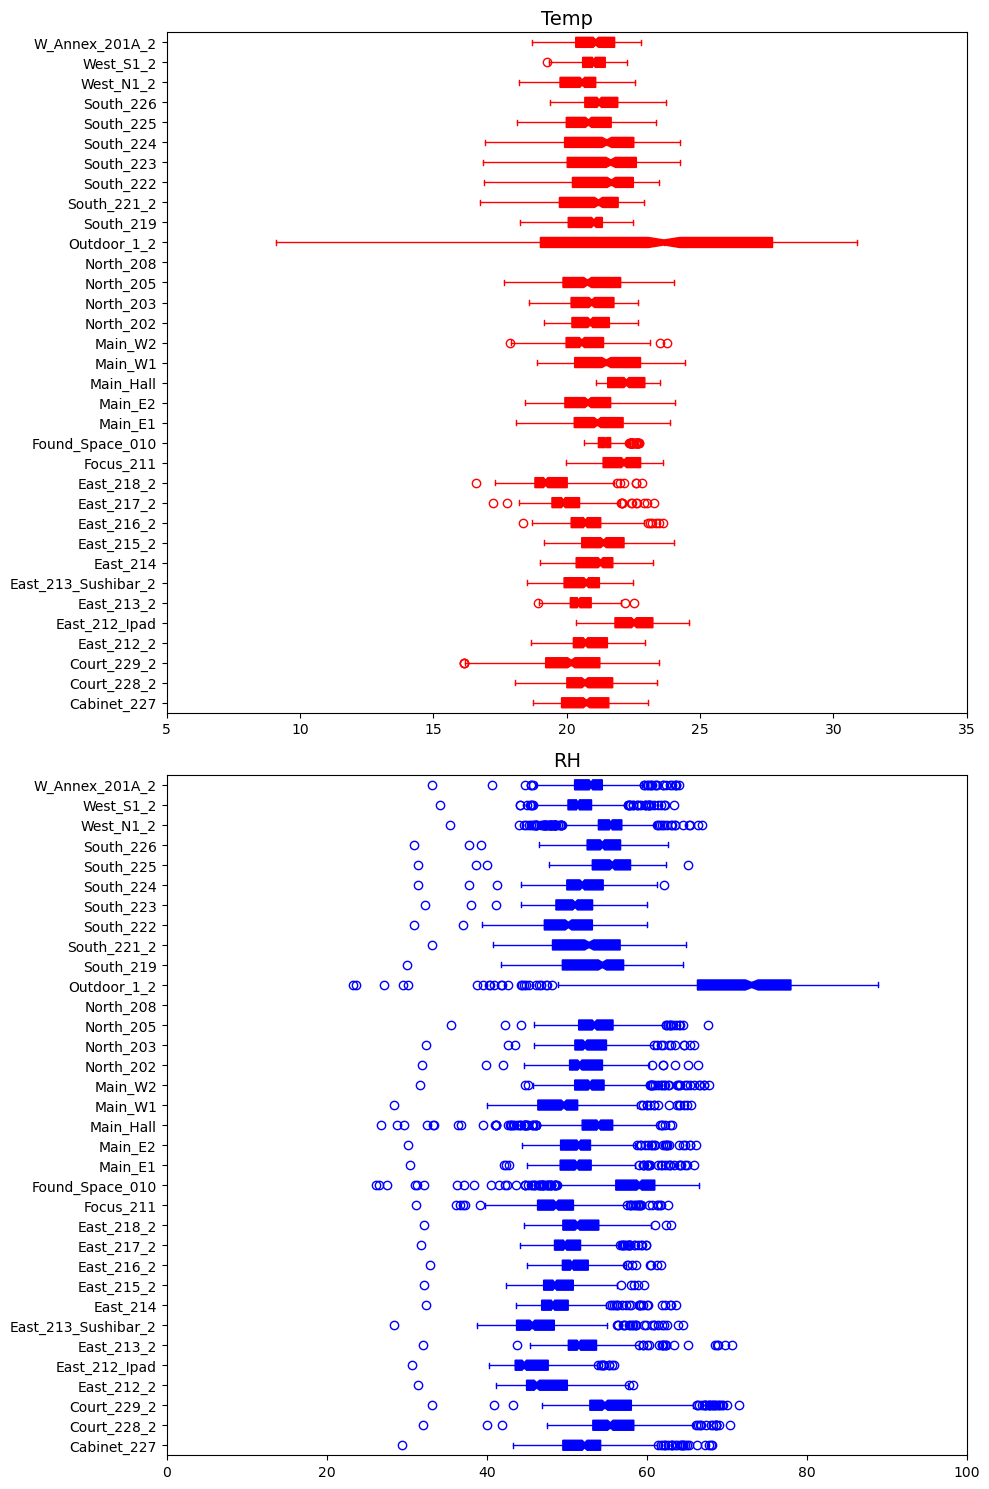

In [70]:
data_temp = []
# convert to pandas data frame
data_temp = pd.DataFrame(data_temp)

# for loop getting samples of Temperature from each sensor
i = 0
for name in names:
    data_temp[name] = dfs[i].set_index('Date').resample(num_samp).mean().reset_index().Temp
    i = i + 1
print(names)

# data format covert to numpy (dataframe covert from pandas to numpy) 
data_temp = data_temp.to_numpy()

# create plots
# subplots (2,1) = two rows, one column, sharex = not using the same x-axis
f2, ax = plt.subplots(2,1,figsize=(10,15),sharex=False)
ax[0].axes.get_xaxis().set_visible(True) #set X axis 
ax[0].axes.get_yaxis().set_visible(True) #set Y axis
c = "red"

# creat box plot for Temp
ax[0].boxplot(data_temp, patch_artist = True,
                notch ='True', vert = 0,
                boxprops=dict(facecolor=c, color=c),
                capprops=dict(color=c),
                whiskerprops=dict(color=c),
                flierprops=dict(color=c, markeredgecolor=c),
                medianprops=dict(color=c))
ax[0].set_yticklabels(names)
ax[0].set_title("Temp", size = 14)
ax[0].set_xlim([5,35])




data_rh = []
# convert to pandas data frame
data_rh = pd.DataFrame(data_rh)

# for loop getting sapmles of RH from each sensor
i = 0
for name in names:
    data_rh[name] = dfs[i].set_index('Date').resample(num_samp).mean().reset_index().RH
    i = i + 1

# data format convert to numpy
data_rh = data_rh.to_numpy()

# create box plot for RH
ax[1].axes.get_xaxis().set_visible(True) #set X axis 
ax[1].axes.get_yaxis().set_visible(True) #set Y axis
c = "blue"
ax[1].boxplot(data_rh, patch_artist = True,
                notch ='True', vert = False,
                boxprops=dict(facecolor=c, color=c),
                capprops=dict(color=c),
                whiskerprops=dict(color=c),
                flierprops=dict(color=c, markeredgecolor=c),
                medianprops=dict(color=c))
ax[1].set_yticklabels(names)
ax[1].set_title("RH", size = 14)
ax[1].set_xlim([0,100])

f2.tight_layout()
plt.show()
f2.savefig('Boxplot')

# Psychrometric chart
## Psychrometric
### Psychrometric

This is some text about something

### New header

More text

Double enter for new line.
Single enter does nothing

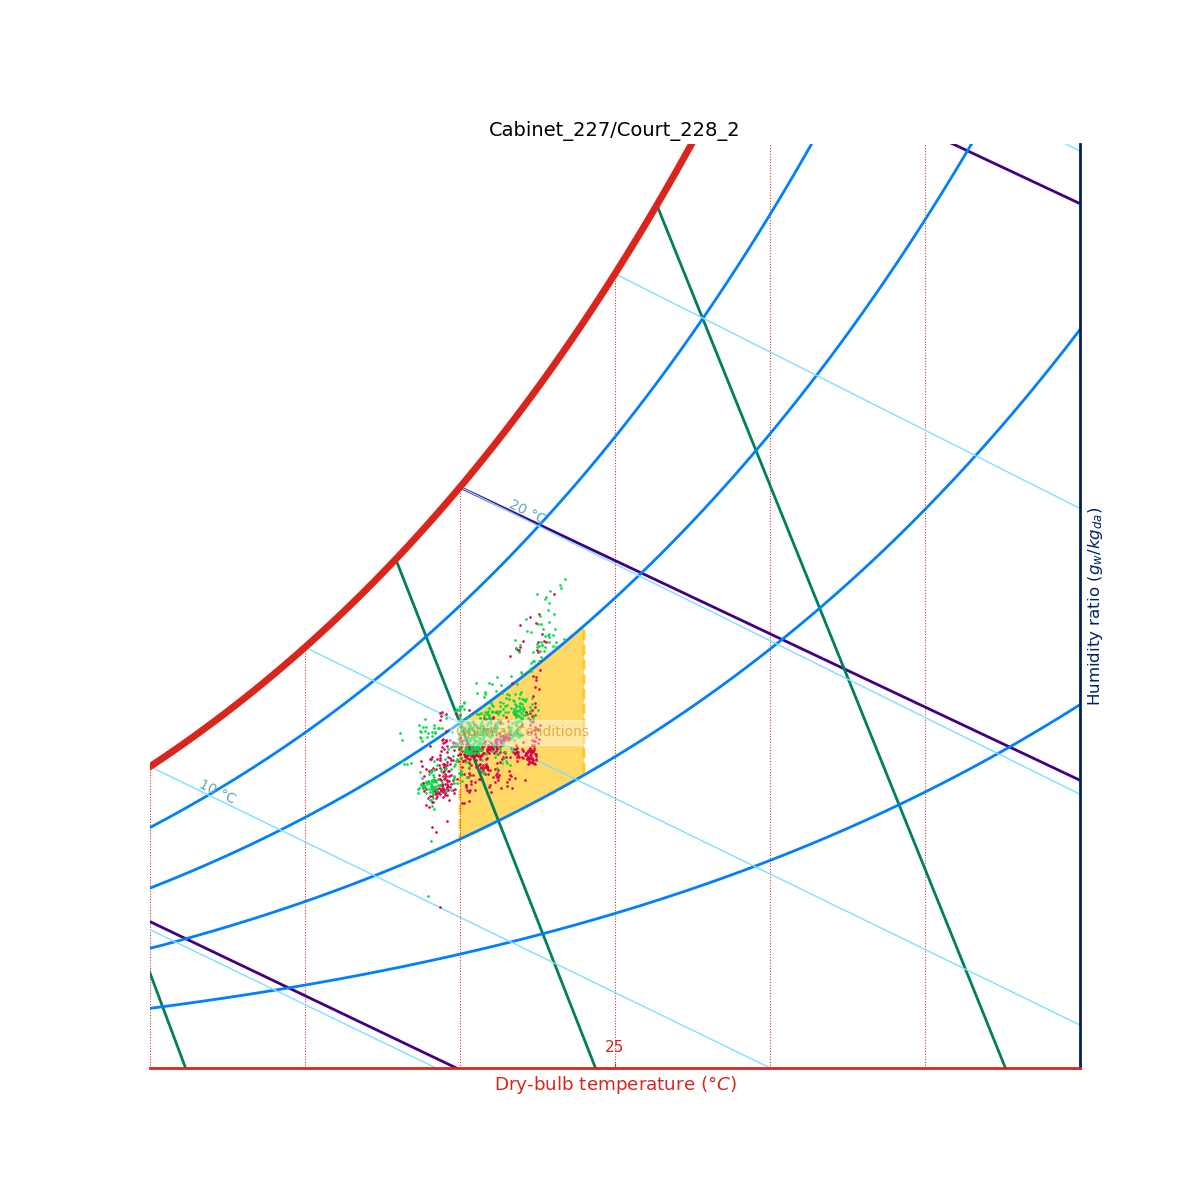

In [71]:
%matplotlib inline
%matplotlib widget
import matplotlib.pyplot as plt

from psychrochart import PsychroChart, load_config

chart = PsychroChart('minimal')
# Append zones:
zones_conf = {
    "zones":[{
            "zone_type": "dbt-rh",
            "style": {"edgecolor": [1.0, 0.749, 0.0, 0.8],
                      "facecolor": [1.0, 0.749, 0.0, 0.6],
                      "linewidth": 2,
                      "linestyle": "--"},
            "points_x": [20, 24],
            "points_y": [40, 60],
            "label": "Optimal Conditions"
        }]}
chart.append_zones(zones_conf)
fig, ax = plt.subplots(figsize=(12, 12))
chart.plot(ax)
#ax = chart.plot()

# Change sensor numbers according to location where we focus
sensor = 0
sensor2 = 1
# 0 is the first value of T/RH
points = {'0': {'label': names[sensor],
                       # RGB values and transparency (closer to 0, more transparent)
                       'style': {'color': [0.855, 0.004, 0.278, 0.8],
                                 'marker': 'X', 'markersize': 1},
                       'xy': (data_temp[0, sensor], data_rh[0, sensor])}
          }
for i in range(1,len(data_temp[:,sensor])):
    points[str(i)] = {'label': names[sensor],
                       'style': {'color': [0.855, 0.004, 0.278, 0.8],
                                 'marker': 'X', 'markersize': 1},
                       'xy': (data_temp[i, sensor], data_rh[i, sensor])}
    
for i in range(len(data_temp[:,sensor2])):
    points[names[sensor2] + str(i)] = {'label': names[sensor2],
                       'style': {'color': [0.004, 0.855, 0.278, 0.8],
                                 'marker': 'X', 'markersize': 1},
                       'xy': (data_temp[i, sensor2], data_rh[i, sensor2])}

chart.plot_points_dbt_rh(points)
#ax.get_figure()
ax.set_title(names[sensor] + "/" + names[sensor2], size = 14)
plt.show()


### Heatmap (RH)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

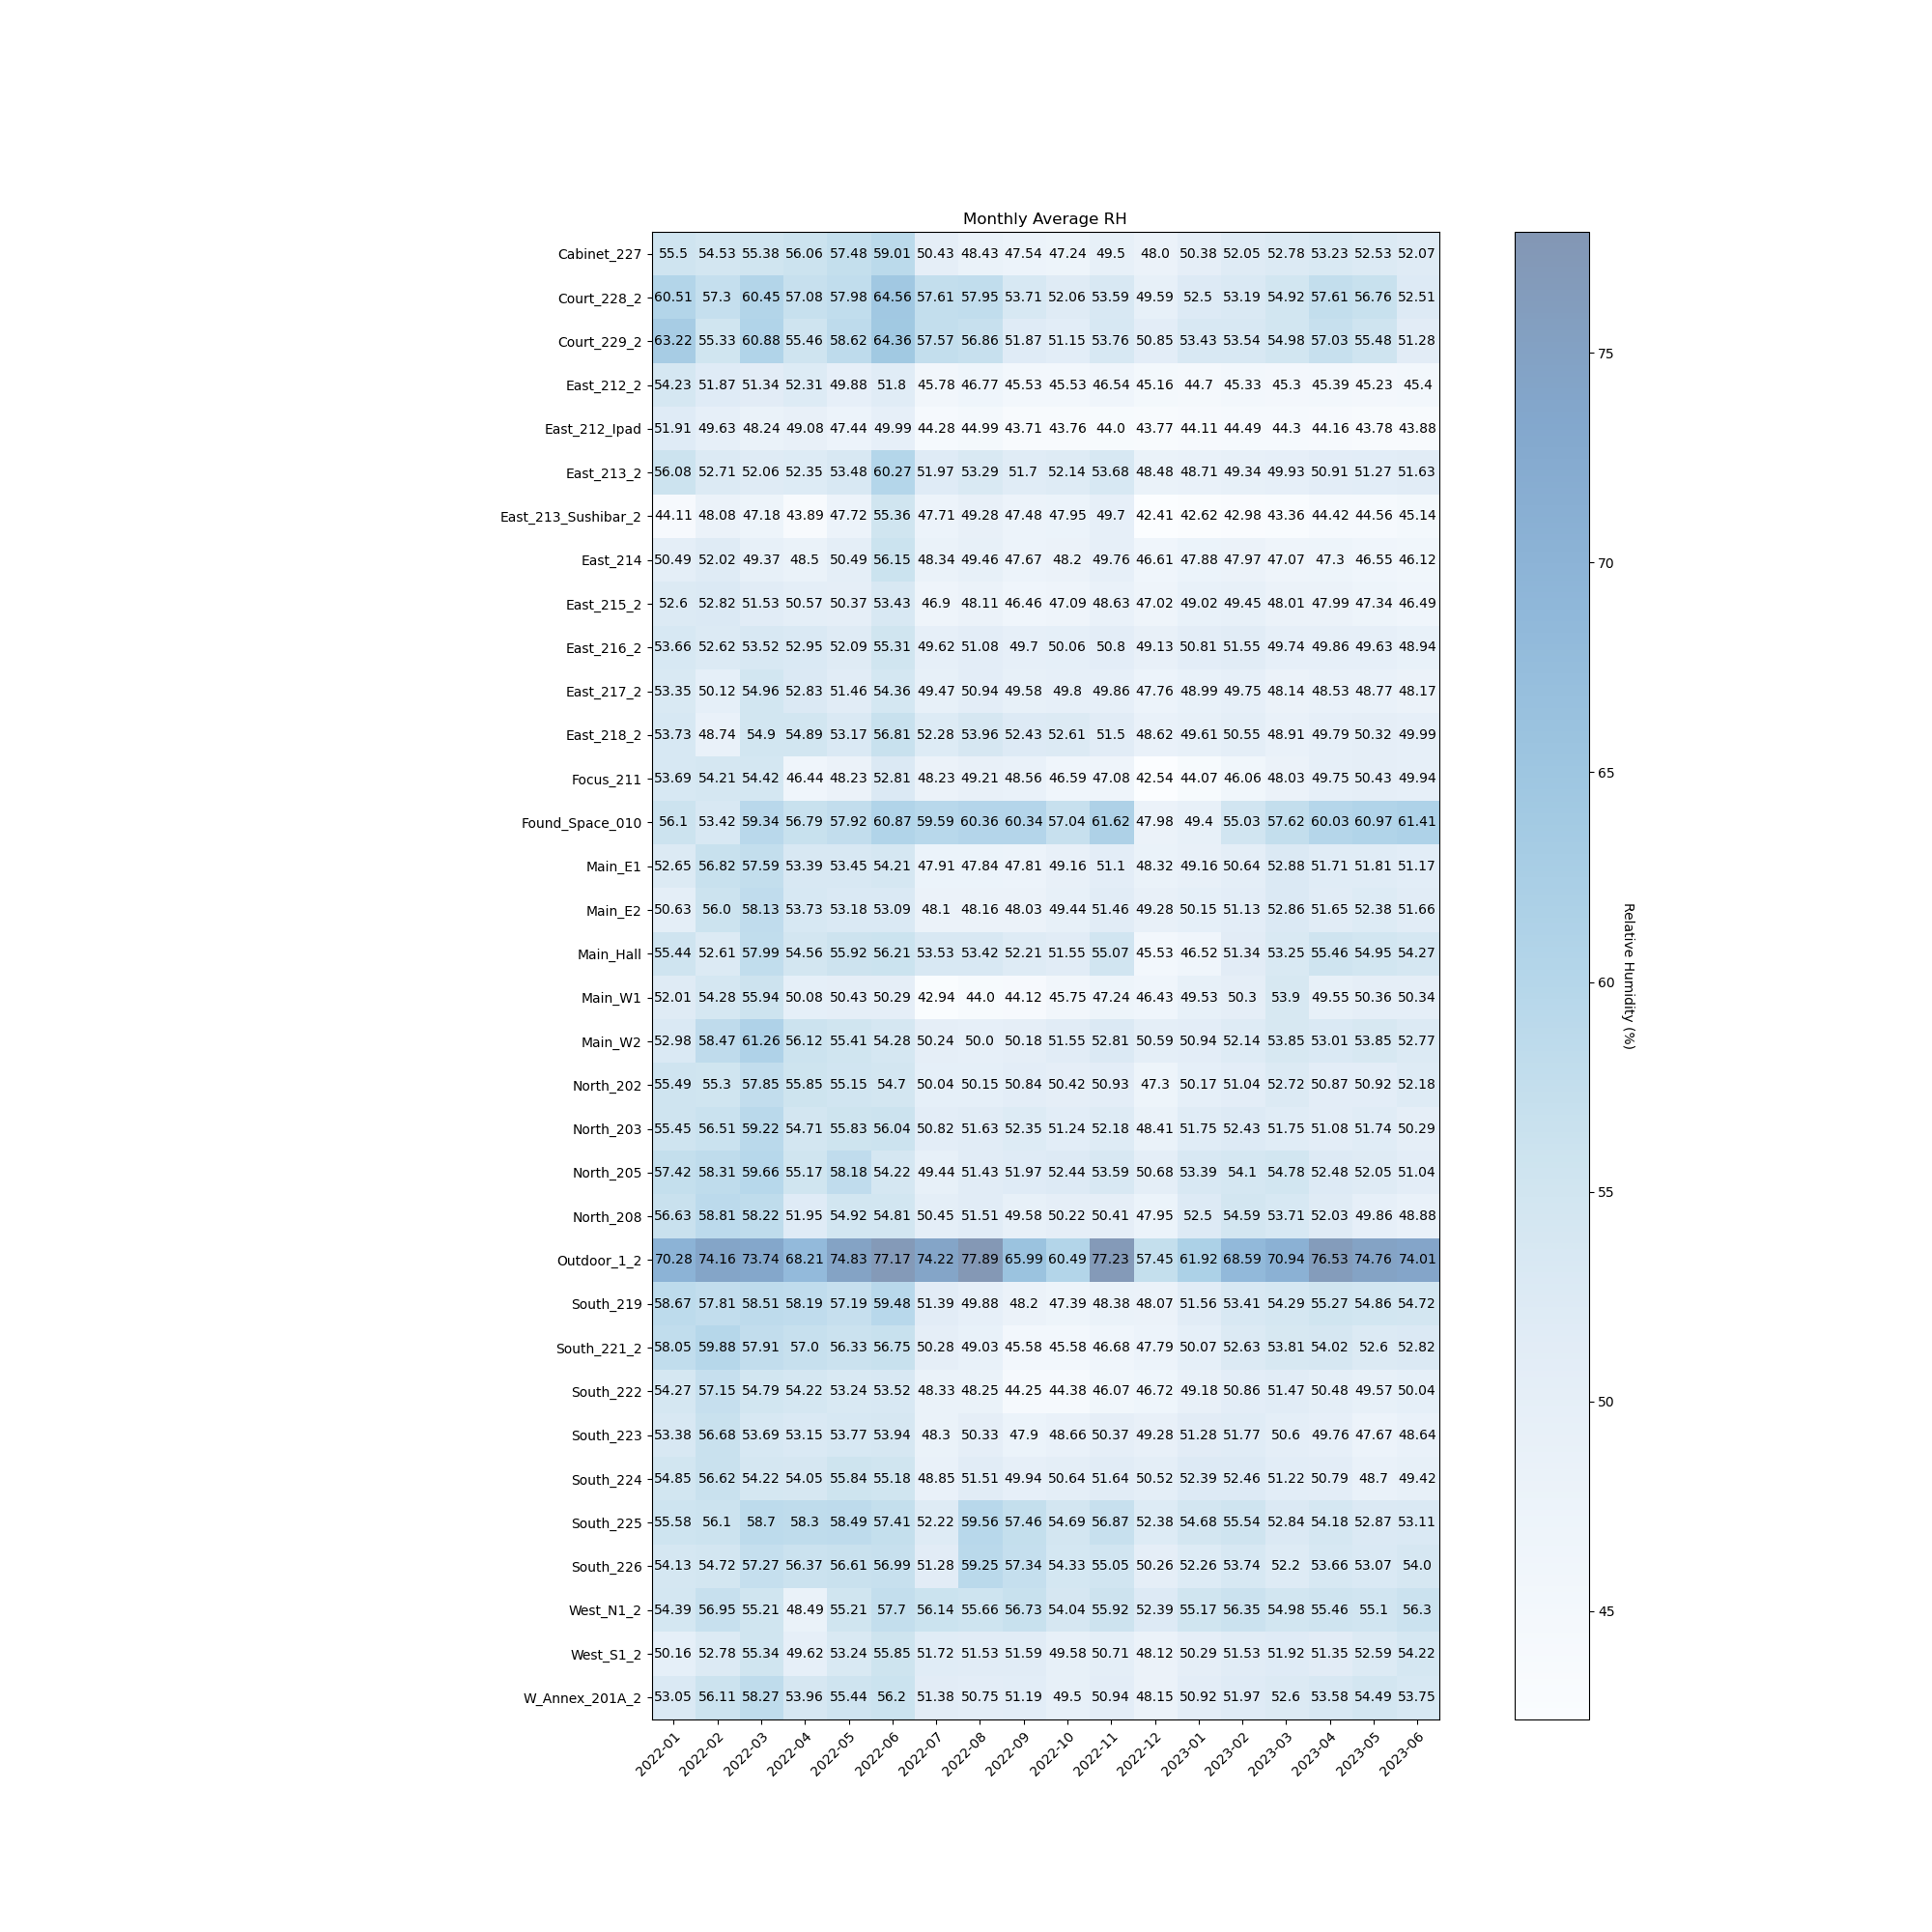

In [77]:
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt


# dfs[0] = the first sensor
AvRH = dfs[0].set_index('Date').resample('1M').mean().reset_index().RH 
Avdate = dfs[0].set_index('Date').resample('1M').mean().reset_index().Date.dt.strftime('%Y-%m')

np_arr = np.zeros((len(names), len(Avdate)))

print(np_arr)
np_arr[0,] = AvRH

#loop
if len(names) > 1:
    for i in range(1,len(names)):
        AvRH = dfs[i].set_index('Date').resample('1M').mean().reset_index().RH
        np_arr[i,] = AvRH
        
np_arr = np_arr.round(2) #decimal points
fig, ax = plt.subplots(figsize=(20,20))

# im = heat map
im = ax.imshow(np_arr, cmap = 'Blues', interpolation='nearest', alpha=0.5)


ax.set_xticks(np.arange(len(Avdate)), labels=Avdate)
ax.set_yticks(np.arange(len(names)), labels=names)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(names)):
    for j in range(len(Avdate)):
        text = ax.text(j, i, np_arr[i, j],
                       ha="center", va="center", color="black")
        
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Relative Humidity (%)', rotation=-90, va="bottom")
#cbar.ax.set_ylim([40,60])

ax.set_title("Monthly Average RH")
#fig.tight_layout()
plt.show()
fig.savefig('Heatmap_RH')


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

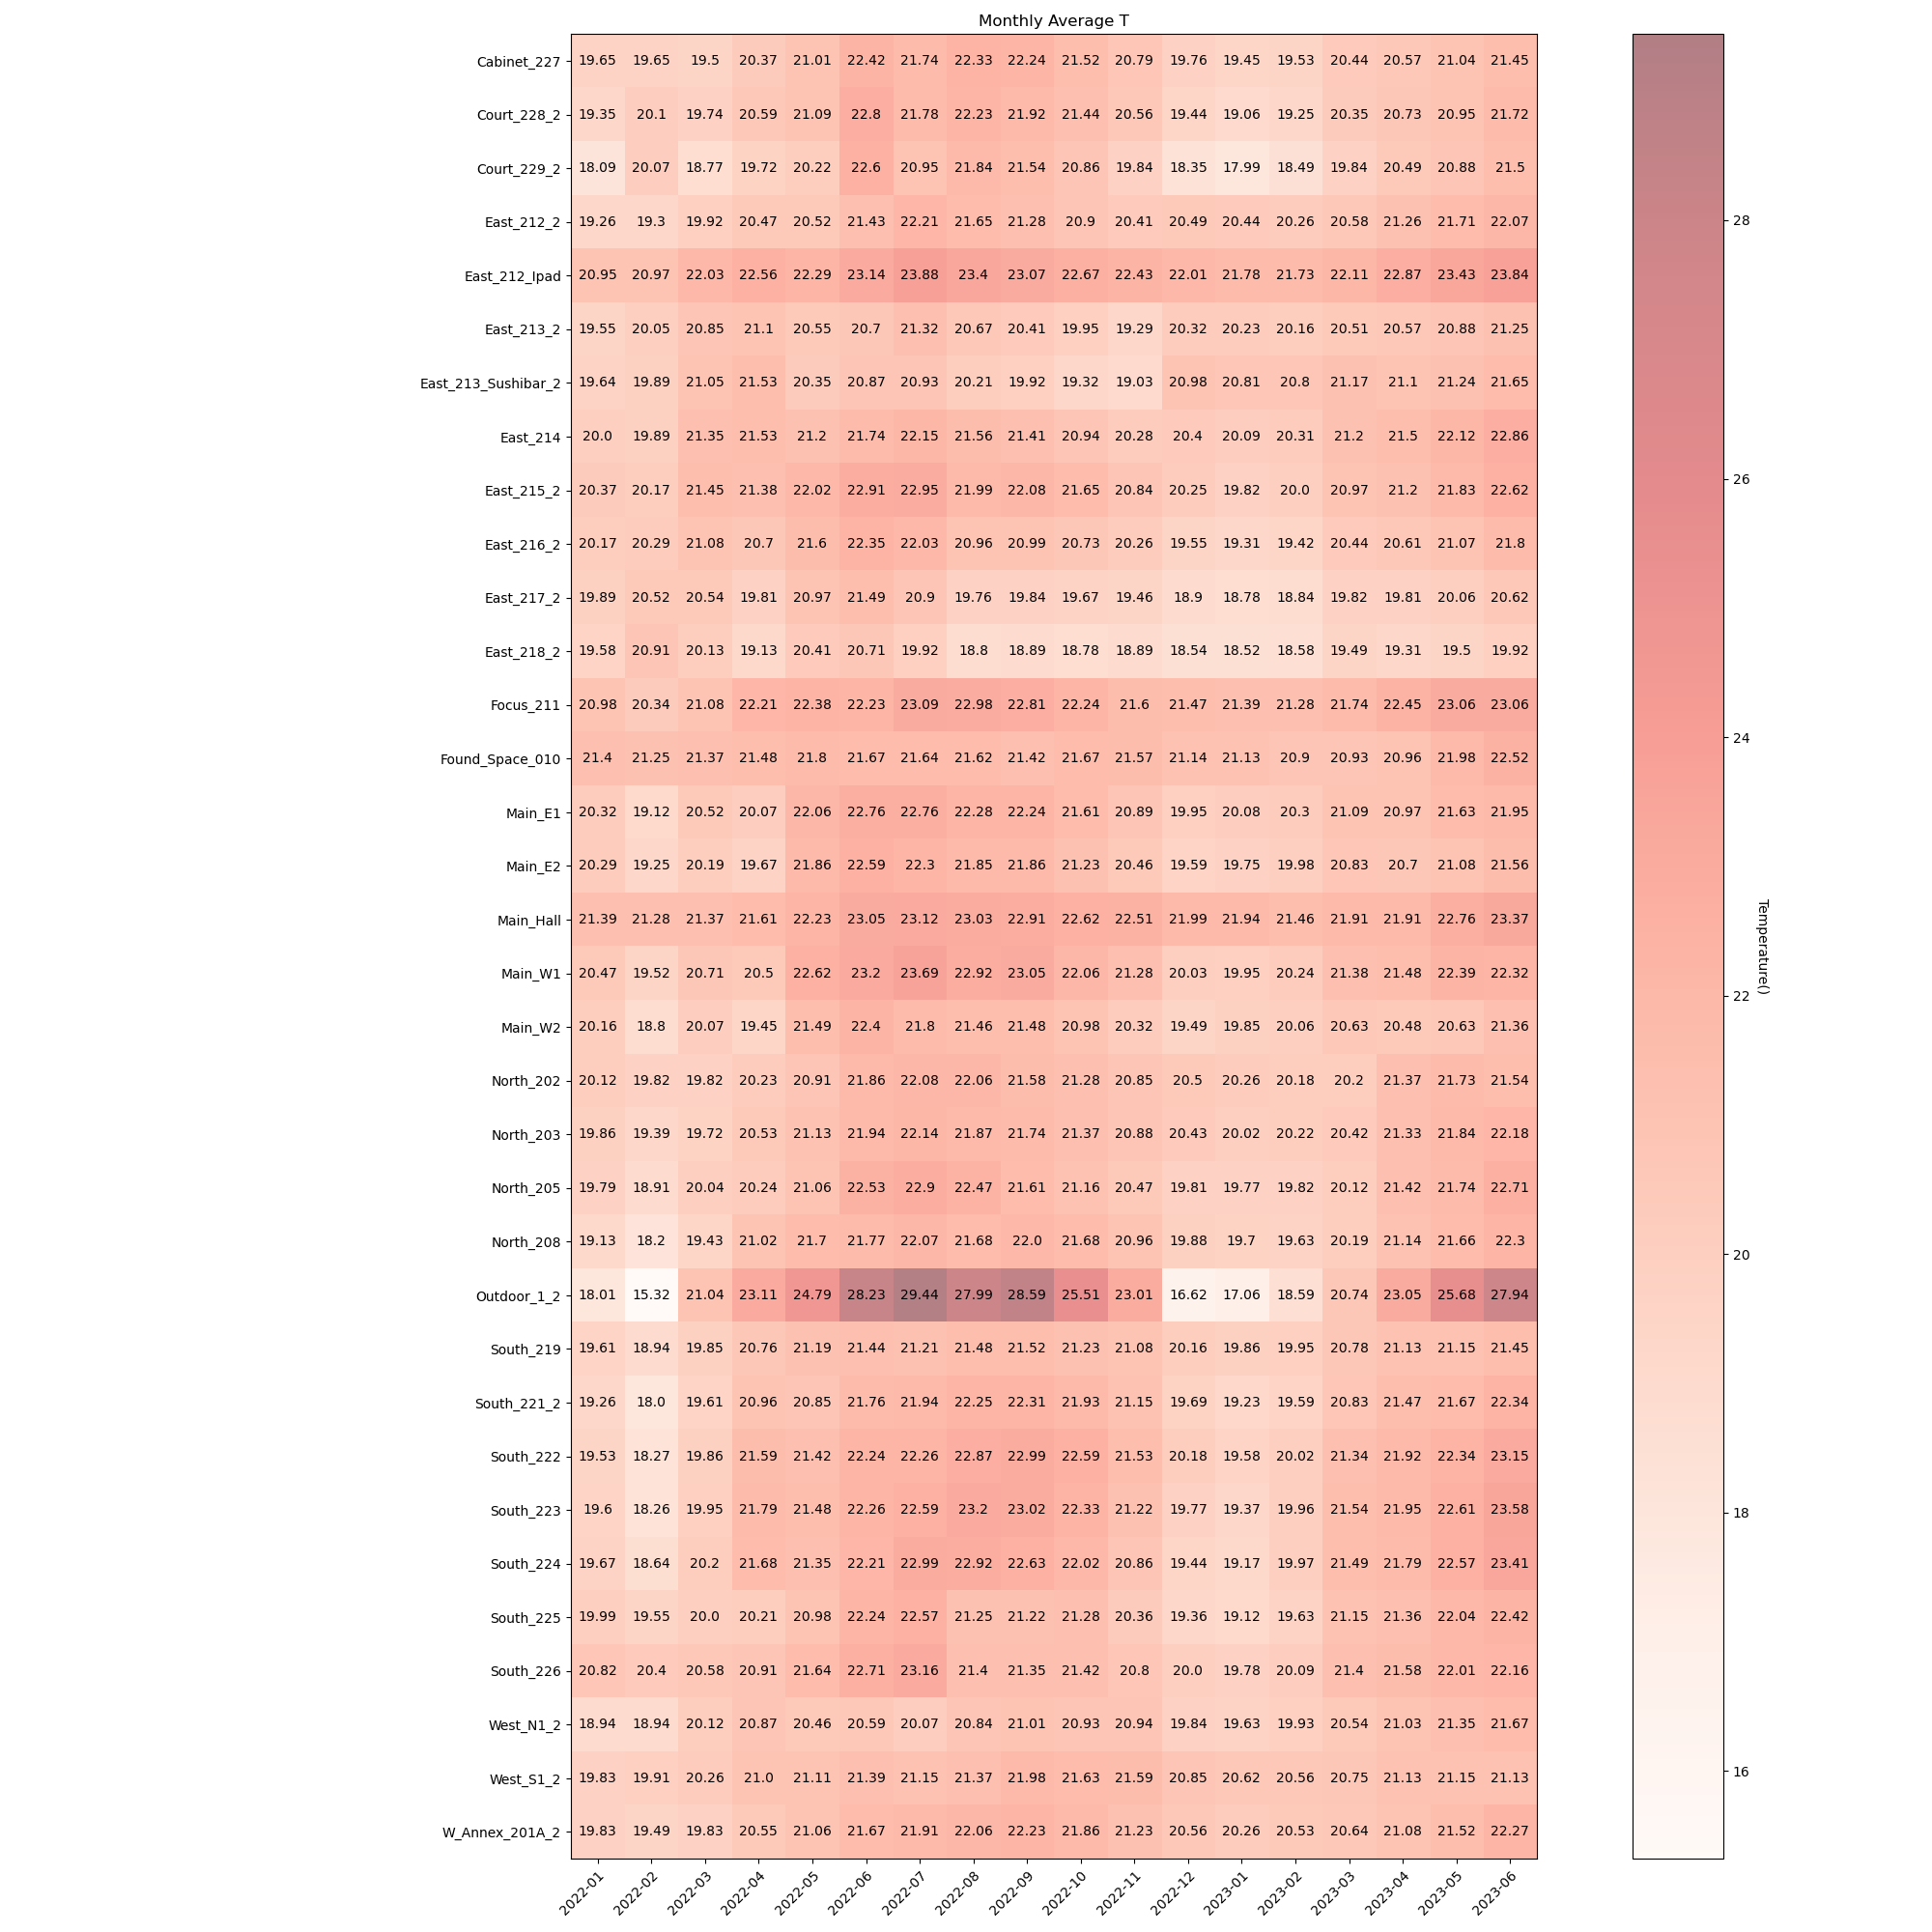

In [78]:
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt


# dfs[0] = the first sensor
AvT = dfs[0].set_index('Date').resample('1M').mean().reset_index().Temp 
Avdate = dfs[0].set_index('Date').resample('1M').mean().reset_index().Date.dt.strftime('%Y-%m')

np_arr = np.zeros((len(names), len(Avdate)))

print(np_arr)
np_arr[0,] = AvT

#loop
if len(names) > 1:
    for i in range(1,len(names)):
        AvT = dfs[i].set_index('Date').resample('1M').mean().reset_index().Temp
        np_arr[i,] = AvT
        
np_arr = np_arr.round(2) #decimal points
fig, ax = plt.subplots(figsize=(20,20))

# im = heat map
im = ax.imshow(np_arr, cmap = 'Reds', interpolation='nearest', alpha=0.5)

ax.set_xticks(np.arange(len(Avdate)), labels=Avdate)
ax.set_yticks(np.arange(len(names)), labels=names)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(names)):
    for j in range(len(Avdate)):
        text = ax.text(j, i, np_arr[i, j],
                       ha="center", va="center", color="black")
        
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Temperature()', rotation=-90, va="bottom")
#cbar.ax.set_ylim([18,25])

ax.set_title("Monthly Average T")
fig.tight_layout()
plt.show()
fig.savefig('Heatmap_T')


In [ ]:
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

#1M = 1 month
# dfs[0] = the first sensor only
AvRH = dfs[0].set_index('DateTime').resample('1M').mean().reset_index().RH 
Avdate = dfs[0].set_index('DateTime').resample('1M').mean().reset_index().DateTime.dt.strftime('%Y-%m')
# np_arr is where we store the information from all sensors
# np.zeros will create an array with zeros as the values (y-axis = len(names), x-axis = len(Avdate))
np_arr = np.zeros((len(names), len(Avdate)))
print(np_arr)
# 0 = the first row of np_arr equals to the AvRH of the first sensor
np_arr[0,] = AvRH

#loop
if len(names) > 1:
    for i in range(1,len(names)):
        AvRH = dfs[i].set_index('DateTime').resample('1M').mean().reset_index().RH
        np_arr[i,] = AvRH
# round(2) = 2 decimal points
np_arr = np_arr.round(2)
fig, ax = plt.subplots()
# im = heat map
im = ax.imshow(np_arr, cmap = 'Blues')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(Avdate)), labels=Avdate)
ax.set_yticks(np.arange(len(names)), labels=names)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(names)):
    for j in range(len(Avdate)):
        text = ax.text(j, i, np_arr[i, j],
                       ha="center", va="center", color="w")
        
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('AvRH', rotation=-90, va="bottom")

ax.set_title("Monthly Average RH")
fig.tight_layout()
plt.show()



# e.g. np.zeros((5,), dtype=int)
# array([0, 0, 0, 0, 0])

#e.g. np.zeros((2, 1))
#array([[ 0.],
       #[ 0.]])


In [ ]:
# importing the modules
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
  
# generating 2-D 10x10 matrix of random numbers
# from 1 to 100
data = np.random.randint(low=1,
                         high=100,
                         size=(10, 10))
  
# setting the parameter values
vmin = 30
vmax = 70
  
# plotting the heatmap
hm = sn.heatmap(data=data,
                vmin=vmin,
                vmax=vmax)
  
# displaying the plotted heatmap
plt.show(

In [20]:
AvRH

NameError: name 'AvRH' is not defined

In [16]:
"outdoor" + str(2)

In [9]:
%matplotlib inline 

num_samp = str('1D')

def g(sensor):
    #Average RH
    AvRH = dfs[sensor].set_index('Date').resample(num_samp).mean().reset_index().RH 
    #Standard error RH
    Std_RH = dfs[sensor].set_index('Date').resample(num_samp).std().reset_index().RH 
    #Average Temp
    AvT = dfs[sensor].set_index('Date').resample(num_samp).mean().reset_index().Temp #average T for Main Gallery 
    #Standard error Temp
    Std_T = dfs[sensor].set_index('Date').resample(num_samp).std().reset_index().Temp #standard error across all sensor and downsamples
    #Average Date
    Avdate = dfs[sensor].set_index('Date').resample(num_samp).mean().reset_index().Date 
    
    counts, xedges, yedges = np.histogram2d(AvT, AvRH, bins=40)
    
    fig, ax = plt.subplots(1,2,figsize=(20,10))
    #sns.despine(left=True, bottom=True, right=True)

    #2D histogram density plot
    ax[0].set_title('Temp-RH ' + names[sensor], size = 24)
    #ax[0].set_facecolor((150/255, 150/255, 150/255)) #set gray background
    ax[0].scatter(AvT,AvRH, s = 30, color="None", edgecolor ="black", alpha =0.8)

    #Color Scatter with sampled pixels
    ax[1].set_title('Density map', size = 24)
    ax[1].imshow(np.rot90(counts))

    plt.show()

interactive_plot2 = interactive(g, sensor=(0, len(names)-1))
output = interactive_plot2.children[-1]
interactive_plot2

interactive(children=(IntSlider(value=0, description='sensor', max=0), Output()), _dom_classes=('widget-intera…

In [ ]:
#Find and print longest column
l=[]

for i in range(len(dfs)):
    date = dfs[i][['Date']]
    l.append(len(date)) #find length of vector and append

longest_column = names[l.index(max(l))]

#apply cubic spline interpolation to entire dataset- based on longest column- 
#for even sampling for all galleries or rooms.


for i in range(len(dfs)):
    cs_T = CubicSpline(dfs[i].Date,dfs[i].Temp)
    cs_RH = CubicSpline(dfs[i].Date,dfs[i].RH)
    index = pd.RangeIndex(start=0, stop=max(l))
    dfs[i] = dfs[i].reindex(index).fillna(method='ffill') #reindex dataframe
    dfs[i].Date = dfs[l.index(max(l))].Date
    dfs[i].Temp = cs_T(dfs[l.index(max(l))].Date)
    dfs[i].RH = cs_RH(dfs[l.index(max(l))].Date)

#convert date floats back to date time format   
for i in range(len(dfs)):
    dfs[i][['Date']]=dates.num2date(dfs[i][['Date']])
   